In [1]:
!pip install ultralytics
!pip install opencv-python numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
!pip install torch torchvision --quiet
import torch
import torch.nn as nn
from torchvision import models


In [3]:
efficientnet = models.efficientnet_b0(pretrained=True)
backbone = efficientnet.features

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 126MB/s] 


In [4]:
for param in backbone[:5].parameters():
    param.requires_grad = False


In [5]:
class YOLOStyleEfficientNet(nn.Module):
    def __init__(self, num_classes, num_anchors=3):
        super(YOLOStyleEfficientNet, self).__init__()
        self.backbone = backbone
        self.detector = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, num_anchors * (5 + num_classes), kernel_size=1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.detector(x)
        return x


In [6]:
class YOLOLoss(nn.Module):
    def __init__(self):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, predictions, targets):
        bbox_loss = self.mse(predictions[..., :4], targets[..., :4])
        obj_loss = self.bce(predictions[..., 4], targets[..., 4])
        cls_loss = self.ce(predictions[..., 5:], targets[..., 5:].argmax(dim=-1))
        return bbox_loss + obj_loss + cls_loss


In [8]:
class YOLOLoss(nn.Module):
    def __init__(self, num_classes=2):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ce = nn.CrossEntropyLoss()
        self.num_classes = num_classes

    def forward(self, predictions, targets):
        pred_box = predictions[..., :4]
        pred_obj = predictions[..., 4]
        pred_cls = predictions[..., 5:]

        target_box = targets[..., :4]
        target_obj = targets[..., 4]
        target_cls = targets[..., 5:]

        bbox_loss = self.mse(pred_box, target_box)
        obj_loss = self.bce(pred_obj, target_obj)

        pred_cls = pred_cls.view(-1, self.num_classes)
        target_cls = target_cls.argmax(dim=-1).view(-1)

        cls_loss = self.ce(pred_cls, target_cls)

        total_loss = bbox_loss + obj_loss + cls_loss
        return total_loss


In [11]:

!pip install torch torchvision --quiet

import torch
import torch.nn as nn
from torchvision import models

efficientnet = models.efficientnet_b0(pretrained=True)
backbone = efficientnet.features
for param in backbone[:5].parameters():
    param.requires_grad = False

class YOLOStyleEfficientNet(nn.Module):
    def __init__(self, num_classes, num_anchors=3):
        super(YOLOStyleEfficientNet, self).__init__()
        self.backbone = backbone
        self.detector = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, num_anchors * (5 + num_classes), kernel_size=1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.detector(x)
        return x

class YOLOLoss(nn.Module):
    def __init__(self, num_classes=2):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ce = nn.CrossEntropyLoss()
        self.num_classes = num_classes

    def forward(self, predictions, targets):
        pred_box = predictions[..., :4]
        pred_obj = predictions[..., 4]
        pred_cls = predictions[..., 5:]

        target_box = targets[..., :4]
        target_obj = targets[..., 4]
        target_cls = targets[..., 5:]

        bbox_loss = self.mse(pred_box, target_box)
        obj_loss = self.bce(pred_obj, target_obj)

        pred_cls = pred_cls.reshape(-1, self.num_classes)
        target_cls = target_cls.argmax(dim=-1).reshape(-1)

        cls_loss = self.ce(pred_cls, target_cls)

        return bbox_loss + obj_loss + cls_loss


model = YOLOStyleEfficientNet(num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = YOLOLoss(num_classes=2)


input_tensor = torch.randn(2, 3, 224, 224)
target_tensor = torch.randn(2, 3 * (5 + 2), 7, 7)
output = model(input_tensor)
pred = output.permute(0, 2, 3, 1).reshape(-1, 7, 7, 3, 7)
target = target_tensor.permute(0, 2, 3, 1).reshape(-1, 7, 7, 3, 7)

loss = loss_fn(pred, target)
loss.backward()
optimizer.step()

print("Training step completed. Loss:", loss.item())


Training step completed. Loss: 2.356994390487671


In [12]:
!pip install roboflow --quiet

from roboflow import Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 133.4 MB/s eta 0:00:00


In [13]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="yBvlPtvwZ3xwA0InnSuZ")
project = rf.workspace("duarte").project("flyingdrones")
version = project.version(5)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to FlyingDrones-5 in yolov8:: 100%|██████████| 8256/8256 [00:01<00:00, 6625.66it/s] 


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [25]:
import os
from glob import glob
import cv2
import torch
import torchvision.transforms as T
import numpy as np

img_dir = "/content/FlyingDrones-5/train/images"
label_dir = "/content/FlyingDrones-5/train/labels"

image_paths = sorted(glob(os.path.join(img_dir, "*.jpg")))
label_paths = sorted(glob(os.path.join(label_dir, "*.txt")))


In [26]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])


In [27]:
def load_yolo_label(label_path, img_width, img_height, num_classes=5, anchors=3):
    target = np.zeros((7, 7, anchors, 5 + num_classes))
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, cx, cy, w, h = map(float, line.strip().split())
            grid_x = int(cx * 7)
            grid_y = int(cy * 7)

            for a in range(anchors):
                target[grid_y, grid_x, a, 0:4] = [cx, cy, w, h]
                target[grid_y, grid_x, a, 4] = 1
                target[grid_y, grid_x, a, 5 + int(cls)] = 1
    return target


In [28]:
img_path = image_paths[0]
label_path = label_paths[0]

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_tensor = transform(image)

h, w, _ = image.shape
target_tensor = load_yolo_label(label_path, w, h)
target_tensor = torch.tensor(target_tensor, dtype=torch.float32)


In [19]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import cv2
import numpy as np
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224))
])

class RoboflowYOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, num_classes=5, anchors=3):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        self.label_paths = sorted(glob(os.path.join(label_dir, "*.txt")))
        self.transform = transform
        self.num_classes = num_classes
        self.anchors = anchors

    def __len__(self):
        return len(self.image_paths)

    def load_yolo_label(self, label_path, img_width, img_height):
        target = np.zeros((7, 7, self.anchors, 5 + self.num_classes))
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, cx, cy, w, h = map(float, line.strip().split())
                grid_x = int(cx * 7)
                grid_y = int(cy * 7)
                for a in range(self.anchors):
                    target[grid_y, grid_x, a, 0:4] = [cx, cy, w, h]
                    target[grid_y, grid_x, a, 4] = 1
                    target[grid_y, grid_x, a, 5 + int(cls)] = 1
        return target

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        if self.transform:
            image = self.transform(image)

        target = self.load_yolo_label(label_path, w, h)
        return image, torch.tensor(target, dtype=torch.float32)


In [20]:
train_dataset = RoboflowYOLODataset(
    image_dir="/content/FlyingDrones-5/train/images",
    label_dir="/content/FlyingDrones-5/train/labels",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)


In [30]:
class YOLOStyleEfficientNet(nn.Module):
    def __init__(self, num_classes=5, num_anchors=3):
        super(YOLOStyleEfficientNet, self).__init__()
        efficientnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.backbone = efficientnet.features
        self.detector = nn.Sequential(
            nn.Conv2d(1280, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, num_anchors * (5 + num_classes), kernel_size=1)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.detector(x)
        return x


In [31]:
class YOLOLoss(nn.Module):
    def __init__(self, num_classes=5):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ce = nn.CrossEntropyLoss()
        self.num_classes = num_classes

    def forward(self, predictions, targets):
        pred_box = predictions[..., :4]
        pred_obj = predictions[..., 4]
        pred_cls = predictions[..., 5:]

        target_box = targets[..., :4]
        target_obj = targets[..., 4]
        target_cls = targets[..., 5:]

        bbox_loss = self.mse(pred_box, target_box)
        obj_loss = self.bce(pred_obj, target_obj)

        pred_cls = pred_cls.reshape(-1, self.num_classes)
        target_cls = target_cls.argmax(dim=-1).reshape(-1)

        cls_loss = self.ce(pred_cls, target_cls)
        return bbox_loss + obj_loss + cls_loss


In [32]:
class RoboflowYOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, num_classes=5, anchors=3):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        self.label_paths = sorted(glob(os.path.join(label_dir, "*.txt")))
        self.transform = transform
        self.num_classes = num_classes
        self.anchors = anchors

    def __len__(self):
        return len(self.image_paths)

    def load_yolo_label(self, label_path, img_width, img_height):
        target = np.zeros((7, 7, self.anchors, 5 + self.num_classes))
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, cx, cy, w, h = map(float, line.strip().split())
                grid_x = int(cx * 7)
                grid_y = int(cy * 7)
                if cls >= self.num_classes:
                    continue
                for a in range(self.anchors):
                    target[grid_y, grid_x, a, 0:4] = [cx, cy, w, h]
                    target[grid_y, grid_x, a, 4] = 1
                    target[grid_y, grid_x, a, 5 + int(cls)] = 1
        return target

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        if self.transform:
            image = self.transform(image)

        target = self.load_yolo_label(label_path, w, h)
        return image, torch.tensor(target, dtype=torch.float32)


In [33]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224))
])

train_dataset = RoboflowYOLODataset(
    image_dir="/content/FlyingDrones-5/train/images",
    label_dir="/content/FlyingDrones-5/train/labels",
    transform=transform,
    num_classes=5
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YOLOStyleEfficientNet(num_classes=5).to(device)
loss_fn = YOLOLoss(num_classes=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        preds = preds.permute(0, 2, 3, 1).reshape(-1, 7, 7, 3, 10)

        loss = loss_fn(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.2013
Epoch [2/10], Loss: 0.1031
Epoch [3/10], Loss: 0.0759
Epoch [4/10], Loss: 0.0577
Epoch [5/10], Loss: 0.0432
Epoch [6/10], Loss: 0.0351
Epoch [7/10], Loss: 0.0264
Epoch [8/10], Loss: 0.0233
Epoch [9/10], Loss: 0.0201
Epoch [10/10], Loss: 0.0170


In [35]:
model = YOLOStyleEfficientNet(num_classes=5).to(device)
loss_fn = YOLOLoss(num_classes=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
...


Ellipsis

In [37]:
model = YOLOStyleEfficientNet(num_classes=5).to(device)
loss_fn = YOLOLoss(num_classes=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        preds = model(imgs)
        preds = preds.permute(0, 2, 3, 1).reshape(-1, 7, 7, 3, 10)

        loss = loss_fn(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.1996
Epoch [2/10], Loss: 0.1048
Epoch [3/10], Loss: 0.0774
Epoch [4/10], Loss: 0.0591
Epoch [5/10], Loss: 0.0451
Epoch [6/10], Loss: 0.0348
Epoch [7/10], Loss: 0.0280
Epoch [8/10], Loss: 0.0226
Epoch [9/10], Loss: 0.0202
Epoch [10/10], Loss: 0.0180


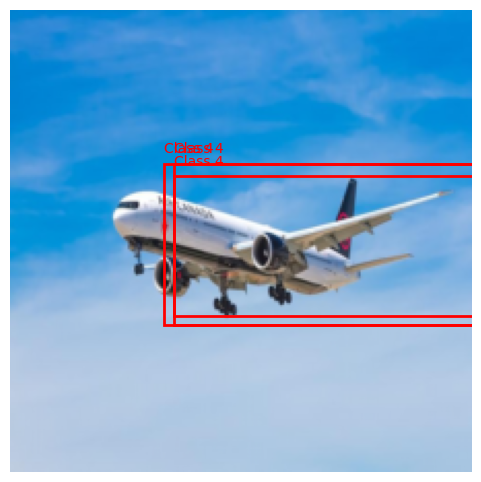

In [41]:
import matplotlib.pyplot as plt

def draw_boxes(image, predictions, threshold=0.4, num_classes=5):
    image = image.permute(1, 2, 0).cpu().numpy()
    h, w, _ = image.shape
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    preds = predictions.permute(1, 2, 0).reshape(7, 7, 3, 5 + num_classes).detach().cpu().numpy()

    for i in range(7):
        for j in range(7):
            for a in range(3):
                pred = preds[i, j, a]
                score = torch.sigmoid(torch.tensor(pred[4])).item()
                if score > threshold:
                    cx, cy, bw, bh = pred[0:4]
                    class_id = np.argmax(pred[5:])
                    label = f"Class {class_id}"

                    x1 = int((j + cx) / 7 * w - bw * w / 2)
                    y1 = int((i + cy) / 7 * h - bh * h / 2)
                    x2 = int((j + cx) / 7 * w + bw * w / 2)
                    y2 = int((i + cy) / 7 * h + bh * h / 2)

                    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                                      fill=False, edgecolor='red', linewidth=2))
                    plt.text(x1, y1 - 5, label, color='red', fontsize=10)
    plt.axis('off')
    plt.show()

model.eval()
with torch.no_grad():
    test_img, _ = train_dataset[2]
    test_pred = model(test_img.unsqueeze(0).to(device))
    draw_boxes(test_img, test_pred[0], num_classes=5)


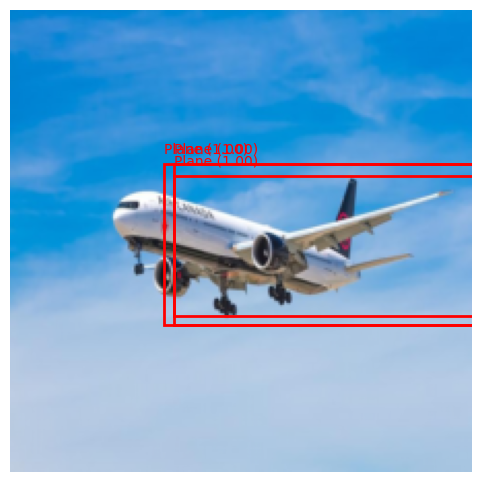

In [43]:
def draw_boxes(image, predictions, threshold=0.4, num_classes=5):
    class_labels = [
        "Bird",
        "Drone",
        "Helicopter",
        "Missile",
        "Plane"
    ]

    image = image.permute(1, 2, 0).cpu().numpy()
    h, w, _ = image.shape
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    preds = predictions.permute(1, 2, 0).reshape(7, 7, 3, 5 + num_classes).detach().cpu().numpy()

    for i in range(7):
        for j in range(7):
            for a in range(3):
                pred = preds[i, j, a]
                score = torch.sigmoid(torch.tensor(pred[4])).item()
                if score > threshold:
                    cx, cy, bw, bh = pred[0:4]
                    class_id = np.argmax(pred[5:])
                    label = class_labels[class_id] if class_id < len(class_labels) else f"Class {class_id}"

                    x1 = int((j + cx) / 7 * w - bw * w / 2)
                    y1 = int((i + cy) / 7 * h - bh * h / 2)
                    x2 = int((j + cx) / 7 * w + bw * w / 2)
                    y2 = int((i + cy) / 7 * h + bh * h / 2)

                    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                                      fill=False, edgecolor='red', linewidth=2))
                    plt.text(x1, y1 - 5, f"{label} ({score:.2f})", color='red', fontsize=10)
    plt.axis('off')
    plt.show()


model.eval()
with torch.no_grad():
    test_img, _ = train_dataset[2]
    test_pred = model(test_img.unsqueeze(0).to(device))
    draw_boxes(test_img, test_pred[0], num_classes=5)


In [39]:
def compute_iou(box1, box2):
    x1_1 = box1[0] - box1[2] / 2
    y1_1 = box1[1] - box1[3] / 2
    x2_1 = box1[0] + box1[2] / 2
    y2_1 = box1[1] + box1[3] / 2

    x1_2 = box2[0] - box2[2] / 2
    y1_2 = box2[1] - box2[3] / 2
    x2_2 = box2[0] + box2[2] / 2
    y2_2 = box2[1] + box2[3] / 2

    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def evaluate_miou(model, dataset):
    model.eval()
    total_iou = 0
    count = 0
    for img, target in dataset:
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(img)
        pred = pred.permute(0, 2, 3, 1).reshape(-1, 7, 7, 3, 10).cpu()
        target = target.unsqueeze(0)
        for i in range(7):
            for j in range(7):
                for a in range(3):
                    if target[0, i, j, a, 4] == 1:
                        box_pred = pred[0, i, j, a, :4]
                        box_true = target[0, i, j, a, :4]
                        total_iou += compute_iou(box_pred, box_true)
                        count += 1
    return total_iou / count if count > 0 else 0

mean_iou = evaluate_miou(model, train_dataset)
print(f"📈 Mean IoU over training data: {mean_iou:.4f}")


📈 Mean IoU over training data: 0.1819


In [45]:
!pip install onnx --quiet
torch.save(model.state_dict(), "efficientnet_yolo.pt")
print("✅ Model saved as efficientnet_yolo.pt")

dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model, dummy_input, "efficientnet_yolo.onnx", input_names=['input'], output_names=['output']) # Now this line should work
print("📦 Exported to efficientnet_yolo.onnx")

traced = torch.jit.trace(model, dummy_input)
traced.save("efficientnet_yolo_script.pt")
print("📦 Exported to efficientnet_yolo_script.pt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 118.9 MB/s eta 0:00:00
✅ Model saved as efficientnet_yolo.pt
📦 Exported to efficientnet_yolo.onnx
📦 Exported to efficientnet_yolo_script.pt


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_iou(box1, box2):
    x1_1 = box1[0] - box1[2] / 2
    y1_1 = box1[1] - box1[3] / 2
    x2_1 = box1[0] + box1[2] / 2
    y2_1 = box1[1] + box1[3] / 2

    x1_2 = box2[0] - box2[2] / 2
    y1_2 = box2[1] - box2[3] / 2
    x2_2 = box2[0] + box2[2] / 2
    y2_2 = box2[1] + box2[3] / 2

    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def evaluate_metrics(model, dataset, iou_threshold=0.5, score_threshold=0.4, num_classes=5):
    model.eval()
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    for img, target in dataset:
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(img)
        pred = pred.permute(0, 2, 3, 1).reshape(-1, 7, 7, 3, 5 + num_classes).cpu().numpy()
        target = target.unsqueeze(0).numpy()

        for i in range(7):
            for j in range(7):
                for a in range(3):
                    pred_box = pred[0, i, j, a]
                    pred_score = 1 / (1 + np.exp(-pred_box[4]))
                    pred_class = np.argmax(pred_box[5:])
                    if pred_score < score_threshold:
                        continue

                    matched = False
                    for ta in range(3):
                        if target[0, i, j, ta, 4] == 1:
                            gt_box = target[0, i, j, ta, :4]
                            gt_class = np.argmax(target[0, i, j, ta, 5:])
                            iou = compute_iou(pred_box[:4], gt_box)
                            if iou >= iou_threshold and pred_class == gt_class:
                                true_positives[pred_class] += 1
                                matched = True
                                break
                    if not matched:
                        false_positives[pred_class] += 1

        for i in range(7):
            for j in range(7):
                for a in range(3):
                    if target[0, i, j, a, 4] == 1:
                        gt_class = np.argmax(target[0, i, j, a, 5:])
                        false_negatives[gt_class] += 1

    precisions, recalls, aps = [], [], []
    for cls in range(num_classes):
        TP = true_positives[cls]
        FP = false_positives[cls]
        FN = false_negatives[cls]

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        ap = precision * recall
        precisions.append(precision)
        recalls.append(recall)
        aps.append(ap)

    mAP = sum(aps) / num_classes

    df = pd.DataFrame({
        "Class ID": list(range(num_classes)),
        "Precision": precisions,
        "Recall": recalls,
        "AP (1-point)": aps
    })

    print(df.to_string(index=False))
    print(f"\n✅ mAP (1-point): {mAP:.4f}")
    return df, mAP

df_metrics, mean_ap = evaluate_metrics(model, train_dataset)


 Class ID  Precision   Recall  AP (1-point)
        0   0.046393 0.045643      0.002118
        1   0.137551 0.119016      0.016371
        2   0.306612 0.233935      0.071727
        3   0.015768 0.015865      0.000250
        4   0.333087 0.237195      0.079007

✅ mAP (1-point): 0.0339
